In [40]:
import torch
from torch import nn

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [41]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'ne'

In [42]:
data_dir = './dataset/corpus/collected/'

In [43]:
import os

src_data_path = os.path.join(data_dir, 'train-small.en')
trg_data_path = os.path.join(data_dir, 'train-small.ne')


In [5]:
import torch
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, source_file, target_file):
        # Load English and Nepali data from files
        with open(source_file, 'r', encoding='utf-8') as f:
            self.src_data = f.readlines()

        with open(target_file, 'r', encoding='utf-8') as f:
            self.trg_data = f.readlines()

    def __len__(self):
        return len(self.english_data)

    def __getitem__(self, idx):
        return (
            self.src_data[idx].lower().strip(),
            self.trg_data[idx].strip()
        )


In [6]:
translation_dataset = TranslationDataset(src_data_path, trg_data_path)


In [7]:
from torch.utils.data.datapipes.iter.sharding import ShardingFilterIterDataPipe

sharding_data_pipe = ShardingFilterIterDataPipe(translation_dataset)

Data preparation process
========================

- Define the paths to the source (English) and target (Nepali) data files.
- Class **TranslationDataset** for creating custom dataset

### **TranslationDataset**
It reads the source and target data from the specified files and stores them in the src_data and trg_data attributes. The __len__ method returns the total number of samples in the dataset. The __getitem__ method retrieves a pair of source and target sentences at the given index. It lowercases the source sentence and removes leading/trailing whitespaces.

- The ShardingFilterIterDataPipe is used for shuffling and splitting the dataset into training, validation, and test sets.


The random_split method is called to split the dataset into training, validation, and test sets. The total_length parameter is set to the length of the original dataset. The weights parameter specifies the proportion of data to be allocated to each set. The seed parameter ensures reproducibility by providing a seed for the random number generator.

This process results in three subsets: train, val, and test, each containing a portion of the original dataset according to the specified weights. These subsets can then be used for training, validation, and testing your machine translation model.


### EDA - simple investigation

In [44]:
sharding_data_pipe

ShardingFilterIterDataPipe

In [45]:
#let's take a look at one example of train
sample = next(iter(sharding_data_pipe))


In [46]:
sample

('it happened after the death of saul, when david was returned from the slaughter of the amalekites, and david had stayed two days in ziklag;',
 'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।')

In [47]:
train_size = len(list(iter(sharding_data_pipe)))
train_size

30000

In [48]:
train, val, test = sharding_data_pipe.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)


In [49]:
train_size = len(list(iter(train)))
train_size

21000

In [50]:
val_size = len(list(iter(val)))
val_size

6000

In [51]:
test_size = len(list(iter(test)))
test_size

3000

###  Preprocessing

In [52]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [17]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [18]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  it happened after the death of saul, when david was returned from the slaughter of the amalekites, and david had stayed two days in ziklag;
Tokenization:  ['it', 'happened', 'after', 'the', 'death', 'of', 'saul', ',', 'when', 'david', 'was', 'returned', 'from', 'the', 'slaughter', 'of', 'the', 'amalekites', ',', 'and', 'david', 'had', 'stayed', 'two', 'days', 'in', 'ziklag', ';']


In [19]:
# nepali language tokenization
from indicnlp.tokenize import indic_tokenize

token_transform[TRG_LANGUAGE] = indic_tokenize.trivial_tokenize

In [20]:
token_transform

{'en': functools.partial(<function _spacy_tokenize at 0x0000019D440D6D40>, spacy=<spacy.lang.en.English object at 0x0000019D4BD5BD90>),
 'ne': <function indicnlp.tokenize.indic_tokenize.trivial_tokenize(text, lang='hi')>}

In [21]:
torch.save(token_transform['en'], './models/en_token.pth')

In [22]:
torch.save(token_transform['ne'], './models/ne_token.pth')

In [23]:

print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।
Tokenization:  ['दाऊदले', 'अमालेकीहरूलाई', 'हराएर', 'पछि', 'सिकलग', 'गए', '।', 'यो', 'शाऊलको', 'मृत्यु', 'भएको', 'केही', 'दिन', 'पछिको', 'कुरा', 'हो', '।', 'दाऊद', 'त्यहाँ', 'दुइ', 'दिन', 'बसे', '।']


In [25]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        # print(data_sample[language_index[language]])
        # if language == 'en':
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index
        # else:
            # yield token_transform[language].trivial_tokenize(data_sample[language_index[language]], lang='hi') #either first or second index


Tokenization Process
=======================

For tokenizing source language(english): **torchtext** is used to obtain a tokenizer based on the specified library and language. In this case, it uses the 'spacy' tokenizer for English.

For tokenizing source language(Nepali): the indic_tokenize.trivial_tokenize function from **indicnlp library** is used. 

- *This, **indicnlp tokenizer** specifically designed for tokenizing Hindi text and since Hindi and Nepali have a same script and writing structure, this is used for tokenizing nepali text.*

Compared to other nepali/hindi tokenizer the **indicnlp** library tokenizer performs very well



**yield_tokens**: This is a helper function that takes a dataset (data) and a language (language) as input. It uses the previously defined token transforms (token_transform) to tokenize the sentences in the dataset based on the specified language.

The language_index dictionary is used to map language names to their corresponding indices in the data samples. For example, **SRC_LANGUAGE** is mapped to 0, and **TRG_LANGUAGE** is mapped to 1.

The function iterates over each data sample, retrieves the text based on the language index, and tokenizes the text using the appropriate tokenizer obtained earlier. It yields a list of tokens for each data sample.

In [26]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)


In [27]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end 
    print(vocab_transform)                                           
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)
    print(vocab_transform)

{'en': Vocab()}
{'en': Vocab(), 'ne': Vocab()}
{'en': Vocab(), 'ne': Vocab()}
{'en': Vocab(), 'ne': Vocab()}


In [28]:
torch.save(vocab_transform['en'], './models/en_vocab.pth')

In [29]:
torch.save(vocab_transform['ne'], './models/ne_vocab.pth')

In [30]:
print(vocab_transform)

{'en': Vocab(), 'ne': Vocab()}


In [31]:
#see some example
vocab_transform[TRG_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[0, 0, 0, 0, 0]

In [32]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1891, for example
mapping[1891]

'stirred'

In [33]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [34]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [35]:
#check unique vocabularies
len(mapping)

7333

Numericalization
=============

The numericalization process involves converting tokenized sentences into sequences of indices based on the vocabulary created. This step is crucial for feeding text data into neural networks or other machine learning models.

Here the vocab transform maps the token to indexes(numbers) and vice versa for source and target language respectiely

###  Preparing the dataloader

In [36]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

In [37]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    # print(type(transforms[0]))
    def func(txt_input):
        for transform in transforms:
            print(transform)
            print(txt_input)
            # if transform.__class__.__name__ == 'module':
            #     print(txt_input)
            #     txt_input = transform(txt_input, lang='hi')
            # else:
            # # print("Hello", transform.__class__.__name__)
            txt_input = transform(txt_input)
        return txt_input
    return func

In [38]:
# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:

    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

In [203]:
# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [34]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

c:\Users\PREDATOR\Music\ML_project\nlp\nlp-assignment-a3\.conda\lib\site-packages\torch\utils\data\graph_settings.py:106: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [35]:
train_loader

In [36]:
for en, _, ne in train_loader:
    break

In [37]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("German shape: ", ne.shape)   # (seq len, batch_size)

English shape:  torch.Size([74, 64])
German shape:  torch.Size([56, 64])


### Design the model
Seq2Seq

In [38]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = (src == self.src_pad_idx).permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        input_ = trg[0, :]
        
        mask   = self.create_mask(src) #(0, 0, 0, 0, 0, 1, 1)
        
        #for each of the input of the trg text
        for t in range(1, trg_len):
            #send them to the decoder
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]
            
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions

### Encoder

In [39]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        #embedding
        embedded = self.dropout(self.embedding(src))
        #packed
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
        #rnn
        packed_outputs, hidden = self.rnn(packed_embedded)
        #unpacked
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #-1, -2 hidden state
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1)))
        
        #outputs: [src len, batch_size, hid dim * 2]
        #hidden:  [batch_size, hid_dim]
        
        return outputs, hidden

### Attention

In [40]:
# class Attention(nn.Module):
#     def __init__(self, hid_dim):
#         super().__init__()
#         self.v = nn.Linear(hid_dim, 1, bias = False)
#         self.W = nn.Linear(hid_dim, hid_dim) #for decoder input_
#         self.U = nn.Linear(hid_dim * 2, hid_dim)  #for encoder_outputs
    
#     def forward(self, hidden, encoder_outputs, mask):
#         #hidden = [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
#         #encoder_outputs = [src len, batch_size, hid_dim * 2]
        
#         batch_size = encoder_outputs.shape[1]
#         src_len    = encoder_outputs.shape[0]
        
#         #repeat the hidden src len times
#         hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
#         #hidden = [batch_size, src_len, hid_dim]
        
#         #permute the encoder_outputs just so that you can perform multiplication / addition
#         encoder_outputs = encoder_outputs.permute(1, 0, 2)
#         #encoder_outputs = [batch_size, src_len, hid_dim * 2]
        
#         #add
#         energy = self.v(torch.tanh(self.W(hidden) + self.U(encoder_outputs))).squeeze(2)
#         #(batch_size, src len, 1) ==> (batch_size, src len)
        
#         #mask
#         energy = energy.masked_fill(mask, -1e10)
        
#         return F.softmax(energy, dim = 1)

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hid_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.v = nn.Linear(hid_dim, 1, bias=False)
        elif attention_type == 'multiplicative':
            self.W = nn.Linear(hid_dim, hid_dim)
        elif attention_type == 'additive':
            self.W1 = nn.Linear(hid_dim, hid_dim)
            self.W2 = nn.Linear(hid_dim, hid_dim)
            self.v = nn.Linear(hid_dim, 1, bias=False)
        else:
            raise ValueError("Invalid attention_type. Choose from 'general', 'multiplicative', or 'additive'.")

        self.U = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, hidden, encoder_outputs, mask):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        if self.attention_type == 'general':
            energy = self.v(torch.tanh(self.U(encoder_outputs))).squeeze(2)
        elif self.attention_type == 'multiplicative':
            # import pdb;pdb.set_trace()
            # print(hidden.size())
            # print(self.W(encoder_outputs).permute(0, 2, 1).size())
            # query @ self.W @ values.T 
            energy = torch.matmul(hidden, self.W(encoder_outputs).permute(0, 2, 1))
        elif self.attention_type == 'additive':
            energy = self.v(torch.tanh(self.W1(hidden) + self.W2(encoder_outputs))).squeeze(2)
        else:
            raise ValueError("Invalid attention_type. Choose from 'general', 'multiplicative', or 'additive'.")

        energy = energy.masked_fill(mask, -1e10)

        return F.softmax(energy, dim=1)


### Decoder

In [84]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input: [batch_size]
        #hidden: [batch_size, hid_dim]
        #encoder_ouputs: [src len, batch_size, hid_dim * 2]
        #mask: [batch_size, src len]
                
        #embed our input
        input    = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch_size, emb_dim]
        
        #calculate the attention
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch_size, src len]
        a = a.unsqueeze(1)
        #a = [batch_size, 1, src len]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_ouputs: [batch_size, src len, hid_dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        #weighted: [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)
        #weighted: [1, batch_size, hid_dim * 2]
        
        #send the input to decoder rnn
            #concatenate (embed, weighted encoder_outputs)
            #[1, batch_size, emb_dim]; [1, batch_size, hid_dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input: [1, batch_size, emb_dim + hid_dim * 2]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
            
        #send the output of the decoder rnn to fc layer to predict the word
            #prediction = fc(concatenate (output, weighted, embed))
        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc(torch.cat((embedded, output, weighted), dim = 1))
        #prediction: [batch_size, output_dim]
            
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Training

In [85]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [54]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

general_attn = Attention(hid_dim)
mult_attn = Attention(hid_dim, attention_type='multiplicative')
add_attn = Attention(hid_dim, attention_type='additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)



In [154]:
len(vocab_transform[SRC_LANGUAGE])

7333

In [157]:
PAD_IDX


1

In [103]:
output_dim 

18612

In [87]:
# General Attention
dec1  = Decoder(output_dim, emb_dim,  hid_dim, dropout, general_attn)
model1 = Seq2SeqPackedAttention(enc, dec1, SRC_PAD_IDX, device).to(device)
model1.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(7333, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(18612, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=18612, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [88]:
# Multiplicative Attention
dec2  = Decoder(output_dim, emb_dim,  hid_dim, dropout, mult_attn)
model2 = Seq2SeqPackedAttention(enc, dec2, SRC_PAD_IDX, device).to(device)
model2.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(7333, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(18612, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=18612, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [89]:
# Additive Attention
dec3  = Decoder(output_dim, emb_dim,  hid_dim, dropout, add_attn)
model3 = Seq2SeqPackedAttention(enc, dec3, SRC_PAD_IDX, device).to(device)
model3.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(7333, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (W1): Linear(in_features=512, out_features=512, bias=True)
      (W2): Linear(in_features=512, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(18612, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=18612, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [90]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    return f'______{sum(params):>6}'
    


In [91]:
print(f"Total parameters of model with general attention is {count_parameters(model1)}")

Total parameters of model with general attention is ______46184372


In [92]:
print(f"Total parameters of model with multiplicative attention is {count_parameters(model2)}")

Total parameters of model with multiplicative attention is ______46446516


In [93]:
print(f"Total parameters of model with additive attention is {count_parameters(model3)}")

Total parameters of model with additive attention is ______46709684


In [94]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [95]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [96]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Start training

In [97]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))


In [98]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [100]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

models = {"general":model1, 'multiplicative':model2, 'additive': model3}
models_lst = [model2, model2, model3]
optimizer_lst = [optimizer2, optimizer2, optimizer3]

training_params = []

for i in range(0,1):

    # if i == 0:
    #     model_name = "Model with general attention"
    #     model_alias = 'generalatt'
    if i == 0:
        model_name = "Model with multiplicative attention"
        model_alias = 'multatt'
    # if i == 2:
    #     model_name = "Model with additive attention"
    #     model_alias = 'addatt'
    
    print(model_name)

    save_path = f'models/{models_lst[i].__class__.__name__}{model_alias}.pt'

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):

        
        start_time = time.time()

        train_loss = train(models_lst[i], train_loader, optimizer_lst[i], criterion, clip, train_loader_length)
        valid_loss = evaluate(models_lst[i], valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(models_lst[i].state_dict(), save_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        training_params.append(
            {
                "Model": model_name,
                "Epoc": f"{epoch+1:02}", 
                "Time" : f"{epoch_mins}m {epoch_secs}s'",
                "Train Loss": f"{train_loss:.3f}",
                "Train PPL": f"{math.exp(train_loss):7.3f}",
                "Val Loss": f"{valid_loss:.3f}",
                "Val PPL": f"{math.exp(valid_loss):7.3f}"
            }
        )

Model with multiplicative attention
> c:\users\predator\appdata\local\temp\ipykernel_25708\3753052001.py(33)forward()

torch.Size([64, 74, 512])
torch.Size([64, 74, 1024])
*** RuntimeError: mat1 and mat2 shapes cannot be multiplied (4736x1024 and 512x512)


In [ ]:
torch.Size([64, 74])

In [ ]:
torch.Size([64, 512])
torch.Size([74, 64, 1024])
torch.Size([74, 64, 1024])

In [58]:
training_params

[{'Model': 'Model with general attention',
  'Epoc': '01',
  'Time': "17m 35s'",
  'Train Loss': '6.986',
  'Train PPL': '1081.825',
  'Val Loss': '6.798',
  'Val PPL': '896.485'},
 {'Model': 'Model with general attention',
  'Epoc': '02',
  'Time': "27m 43s'",
  'Train Loss': '6.268',
  'Train PPL': '527.426',
  'Val Loss': '6.727',
  'Val PPL': '834.508'},
 {'Model': 'Model with general attention',
  'Epoc': '03',
  'Time': "32m 17s'",
  'Train Loss': '5.947',
  'Train PPL': '382.565',
  'Val Loss': '6.691',
  'Val PPL': '805.110'},
 {'Model': 'Model with general attention',
  'Epoc': '04',
  'Time': "33m 10s'",
  'Train Loss': '5.682',
  'Train PPL': '293.455',
  'Val Loss': '6.674',
  'Val PPL': '791.714'},
 {'Model': 'Model with general attention',
  'Epoc': '05',
  'Time': "33m 27s'",
  'Train Loss': '5.439',
  'Train PPL': '230.116',
  'Val Loss': '6.700',
  'Val PPL': '812.775'},
 {'Model': 'Model with general attention',
  'Epoc': '06',
  'Time': "33m 29s'",
  'Train Loss': '5

In [106]:
model1.load_state_dict(torch.load('./models/Seq2SeqPackedAttentiongeneralatt.pt'))
test_loss = evaluate(model1, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 6.582 | Test PPL: 722.102 |


In [108]:
model1

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(7333, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(18612, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=18612, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [109]:
sample[0]

'it happened after the death of saul, when david was returned from the slaughter of the amalekites, and david had stayed two days in ziklag;'

In [110]:
sample[1]

'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।'

In [111]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,   26,  199,  120,    5,  230,    7,  540,    4,   56,  136,   37,
         475,   38,    5, 1368,    7,    5, 4427,    4,    6,  136,   66,  800,
         133,  130,   11, 4404,   14,    3], device='cuda:0')

In [112]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,  244,    0, 5675,  140,    0,  109,    4,   20, 2576,  355,   42,
          70,   90, 6023,   81,   33,    4,  431,   76,  350,   90,  438,    4,
           3], device='cuda:0')

In [113]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [114]:
trg_text = trg_text.reshape(-1, 1)

In [115]:
src_text.shape, trg_text.shape


(torch.Size([30, 1]), torch.Size([25, 1]))

In [140]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)
SRC_LANGUAGE

'en'

In [202]:
model1.load_state_dict(torch.load('./models/Seq2SeqPackedAttentiongeneralatt.pt'))

def translate_eng_to_nepali(src, model):
    # trg_text = ''
    SRC_LANGUAGE = 'en'
    TRG_LANGUAGE = 'ne'
    src_text = text_transform[SRC_LANGUAGE](src).to(device)
    src_text = src_text.reshape(-1, 1)
    trg_text = text_transform[TRG_LANGUAGE]('').to(device)
    trg_text = trg_text.reshape(-1, 1)
    text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)
    esc_chars = ['<sos>', '<unk>', '<eos>', '।']
    model.eval()
    with torch.no_grad():
        output, attentions = model(src_text, text_length, trg_text, 0) 
    output = output.squeeze(1)
    output = output[1:]
    output_max = output.argmax(1) 
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
    trg_tokens = [trg for trg in trg_tokens if trg not in esc_chars]
    return ' '.join(trg_tokens)

src = 'When he had made an end of prophesying, he came to the high place.'   




translate_eng_to_nepali(src, model1)


functools.partial(<function _spacy_tokenize at 0x000002389DC57B50>, spacy=<spacy.lang.en.English object at 0x0000023A490179A0>)
When he had made an end of prophesying, he came to the high place.
Vocab()
['When', 'he', 'had', 'made', 'an', 'end', 'of', 'prophesying', ',', 'he', 'came', 'to', 'the', 'high', 'place', '.']
<function tensor_transform at 0x000002389AE4BA30>
[0, 13, 66, 92, 114, 292, 7, 2796, 4, 13, 78, 9, 5, 231, 144, 8]
<function trivial_tokenize at 0x000002389AE4A8C0>

Vocab()
['']
<function tensor_transform at 0x000002389AE4BA30>
[0]


'तब त्यो'

In [153]:
model1.load_state_dict(torch.load('./models/Seq2SeqPackedAttentiongeneralatt.pt'))

model1.eval()
with torch.no_grad():
    output, attentions = model1(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [120]:
output.shape #trg_len, batch_size, trg_output_dim


torch.Size([25, 1, 18612])

In [121]:
output = output.squeeze(1)


In [122]:
output.shape


torch.Size([25, 18612])

In [123]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([24, 18612])

In [124]:
output_max = output.argmax(1) #returns max indices


In [125]:
output_max

tensor([3052,    0,    0,    0,    0,    4,    4,    4,    3,    4,    3,    4,
           3,    4,    3,    4,    3,    4,    3,    4,    3,    3,    4,    3],
       device='cuda:0')

In [126]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()


In [127]:
for token in output_max:
    print(mapping[token.item()])

भोलिपल्ट
<unk>
<unk>
<unk>
<unk>
।
।
।
<eos>
।
<eos>
।
<eos>
।
<eos>
।
<eos>
।
<eos>
।
<eos>
<eos>
।
<eos>


### Attention

In [128]:
attentions.shape

torch.Size([25, 1, 30])

In [129]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'it',
 'happened',
 'after',
 'the',
 'death',
 'of',
 'saul',
 ',',
 'when',
 'david',
 'was',
 'returned',
 'from',
 'the',
 'slaughter',
 'of',
 'the',
 'amalekites',
 ',',
 'and',
 'david',
 'had',
 'stayed',
 'two',
 'days',
 'in',
 'ziklag',
 ';',
 '<eos>']

In [130]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'भोलिपल्ट',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '।',
 '।',
 '।',
 '<eos>',
 '।',
 '<eos>',
 '।',
 '<eos>',
 '।',
 '<eos>',
 '।',
 '<eos>',
 '।',
 '<eos>',
 '।',
 '<eos>',
 '<eos>',
 '।',
 '<eos>']

In [134]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_25708\3489918703.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\PREDATOR\AppData\Local\Temp\ipykernel_25708\3489918703.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\PREDATOR\Music\ML_project\nlp\nlp-assignment-a3\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 2349 (\N{DEVANAGARI LETTER BHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PREDATOR\Music\ML_project\nlp\nlp-assignment-a3\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PREDATOR\Music\ML_project\nlp\nlp-assignment-a3\.conda\li

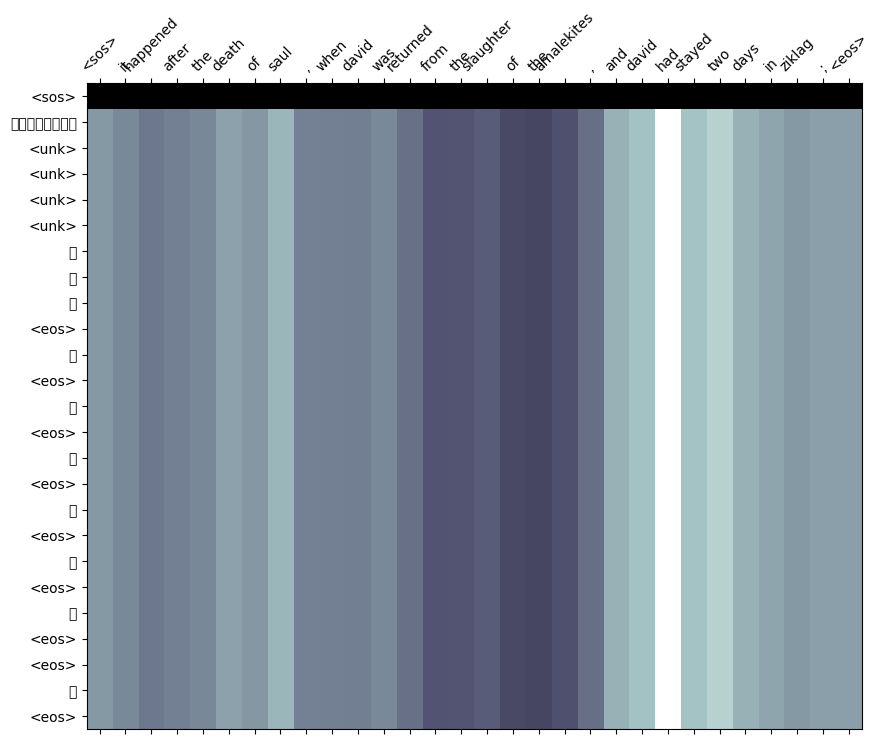

In [135]:
display_attention(src_tokens, trg_tokens, attentions)
